In [1]:
import spacy
import textacy
import numpy as np
import pandas as pd 

# Define global variables

In [2]:
MAX_NUM = 1000
RAW_REVIEW_JSON = './data/review.json'

In [3]:
nlp = spacy.load('en_core_web_sm')

# Phrase Model

## Prepare Sentence (tokens) List

In [8]:
# yield entire text for one review
def generate_review():
    reviews = textacy.io.read_json(RAW_REVIEW_JSON, mode='rt', lines=True)
    for review in reviews:
        yield review['text']

In [9]:
# define rules to filter out unuseful tokens
def filter_token(token):
    if(token.is_punct or \
       token.is_digit or \
       token.is_space or \
       token.like_num):
        return(False)
    else:
        return(True)

In [10]:
# generate a list with [[sentence 1 token 1, sentence 1 token 2], ..., [sentence 1 token K],[tokens in sentence 2]]
def generate_list(max_num = MAX_NUM):
    count = 0
    df = []
    for doc in nlp.pipe(generate_review(), batch_size=10, n_threads=3):
        for sent in doc.sents:
            # 1. filter out based on rules
            # 2. lemmatize
            df.append( [token.lemma_ for token in sent if filter_token(token)] )

        count += 1
        if count>= max_num: 
            break
    return(df)

In [11]:
unigram_sentences = generate_list()
len(unigram_sentences) # Number of sentences in corpus

13050

## Train phrase model

In [18]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [19]:
bigram_model = Phraser(Phrases(unigram_sentences))
trigram_model = Phraser(Phrases(bigram_model[unigram_sentences]))

## Apply Phrase Model

In [25]:
# generate a list with [[doc 1 token 1, doc 1 token 2], ..., [doc 1 token K],[tokens in doc 2]]
def apply_phrase_model(max_num = MAX_NUM):
    df = []
    count = 0
    for doc in nlp.pipe(generate_review(), batch_size=10, n_threads=3):
        # 1. filter out based on rules
        # 2. lemmatize
        # 3. apply bigram and trigram phrase model
        
        unigram_review =  [token.lemma_ for token in doc if filter_token(token)]
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]
        
        df.append(trigram_review)
        
        count += 1
        if count>= max_num: 
            break
    return(df)

In [26]:
phrased_reviews = apply_phrase_model()
len(phrased_reviews)

1000

# Topic Modelling

<img src="https://s3.amazonaws.com/skipgram-images/LDA.png" width= 400>

## Create Document-Term Matrix

In [50]:
vectorizer = textacy.vsm.Vectorizer(tf_type='linear', min_df = 3)
doc_term_matrix = vectorizer.fit_transform(phrased_reviews)
doc_term_matrix

<1000x3402 sparse matrix of type '<class 'numpy.int32'>'
	with 83287 stored elements in Compressed Sparse Row format>

## Train Topic Model

In [63]:
model = textacy.tm.TopicModel('lda', n_topics=3) 
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

/Users/shiwang/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


(1000, 3)

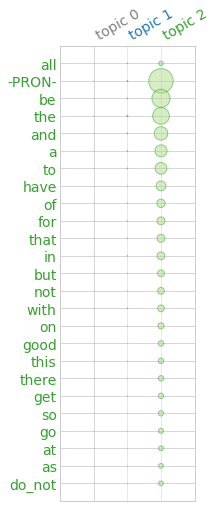

In [66]:
model.termite_plot(doc_term_matrix,  vectorizer.id_to_term,
                  highlight_topics=[1,2])

## Need to remove some words
TBD